# IE 534 HW: Reinforcement Learning
    v1, Designed for IE 534/CS 547 Deep Learning, Fall 2019 at UIUC

In this assignment, we will experiment with the (deep) reinforcement learning algorithms covered in the lecture. In particular, you will implement variants of the popular `DQN` (Deep Q-Network) (1) and `A2C` (Advantage Actor-Critic) (2) algorithms (by the same first author! orz), and test your implementation on both a small example (CartPole problem) and an Atari game (Breakout game). We focus on model-free algorithms rather than model-based ones, because neural nets are easier applicable and more popular nowadays in the model-free setting. (When the system dynamic is known or can be easily inferred, model-based can sometimes do better.)

The assignment breaks into **three parts**:

- **In Part I** (50 pts), you basically need to follow the instructions in this notebook to do a little bit of coding. We'll be able to see if your code trains by testing against the CartPole environment provided by the OpenAI gym package. We'll generate some plots that are required for grading.

- **In Part II** (40 pts), you'll copy your code onto Blue Waters (or actually any good server..), and run a much larger-scale experiment with the Breakout game. Hopefully, you can teach the computer to play Breakout in less than half a day! Share your final game score in this notebook. **<font color=red>This part will take at least a day. Please start early!!</font>**

- **In Part III** (10 pts), you'll be asked to think about a few questions. These questions are mostly open-ended. Please write down your thoughts on them.

Finally, after you finished everything in this notebook **<font color=red>(code snippets C1-C5, plots P1-P5, question answers Q1-Q5)</font>**, please save the notebook, and export to a PDF (or an HTML file), and submit:
    
1. the **.ipynb notebook and exported .pdf/.html file**, PDF is preferred (I usually do File -> Print Preview -> use Chrome's Save as PDF);

2. your code (**Algo.py, Model.py files**);

3. job artifacts (**.log files** only, pytorch models and images not required)

to Compass 2g for grading.

**PS: Remember to save your notebook occasionally as you work through it!**

#### References

- (1) Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A.A., Veness, J., Bellemare, M.G., Graves, A., Riedmiller, M., Fidjeland, A.K., Ostrovski, G. and Petersen, S., 2015. Human-level control through deep reinforcement learning. Nature, 518(7540), p.529.
- (2) Mnih, V., Badia, A.P., Mirza, M., Graves, A., Lillicrap, T., Harley, T., Silver, D. and Kavukcuoglu, K., 2016, June. Asynchronous methods for deep reinforcement learning. In International conference on machine learning (pp. 1928-1937).
- (3) A useful tutorial: https://spinningup.openai.com/en/latest/
- (4) *Useful code references*: https://github.com/deepmind/bsuite; https://github.com/openai/baselines; https://github.com/astooke/rlpyt;

***
First of all, **enter your NetID here** in the cell below:

## Part I: DQN and A2C on CartPole
***
This part is designed to run on your own local laptop/PC.

Before you start, there are some python dependencies: `pytorch, gym, numpy, multiprocessing, matplotlib`. Please install them correctly. You can install `pytorch` following instruction here https://pytorch.org/get-started/locally/. The code is compatible with PyTorch 0.4.x ~ 1.x. PyTorch 1.1 with cuda 10.0 worked for me (`conda install pytorch==1.1.0 torchvision==0.3.0 cudatoolkit=10.0 -c pytorch`).

Please <font color=red>**always**</font> run the code cell below each time you open this notebook, to make sure `gym` is installed and to enable `autoreload` which **allows code changes to be effective immediately**. So if you changed `Algo.py` or `Model.py` but the test codes are not reflecting your changes, restart the notebook kernel and run this cell!!

In [1]:
# install openai gym
%pip install gym
# enable autoreload
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


### 1.1 Code Structure

The code is structured in 5 python files:

- `Main.py`: contains the main entry point and training loop
- `Model.py`: constructs the torch neural network modules
- `Env.py`: contains the environment simulations interface, based on openai gym
- `Algo.py`: implements the DQN and A2C algorithms
- `Replay.py`: implements the experience replay buffer for DQN
- `Draw.py`: saves some game snapshots to jpeg files

Some parts of the code `Model.py` and `Algo.py` are left blank for you to complete. You are not required to modify the other parts (unless, of course, you want to boost the performance!). This is kind of a minimalist implementation, and might be different from the other code on the internet in details. You're welcomed to improve it,  after you've finished all the required things of this assignment.

### 1.2 OpenAI gym and CartPole environment
OpenAI developed python package `gym` a while ago to facilitate RL research. `gym` provides a common interface between the program and the environments. For instance, the code cell below will create the CartPole environment. A window will show up when you run the code. The goal is to keep adjusting the cart so that the pole stays in its upright position.

A demo video from OpenAI:
<video width="320" controls src="http://s3-us-west-2.amazonaws.com/rl-gym-doc/cartpole-no-reset.mp4" />

`gym` also provides interface to Atari games. However, installing package `atari-py` is not easy on Windows/Mac, so we won't demonstrate it here. More info: http://gym.openai.com/docs/.

In [1]:
import time
import gym
env = gym.make('CartPole-v1')
env.reset()
for _ in range(200):
    env.render()
    state, reward, done, _ = env.step(env.action_space.sample()) # take a random action
    if done: break
    time.sleep(0.15)
env.close()

### 1.3 Deep Q Learning

A little recap on DQN. We learned from lecture that Q-Learning is a model-free reinforcement learning algorithm. It falls into the off-policy type algorithm since it can utilize past experiences stored in a buffer. It also falls into the (approximate) dynamic programming type algorithm, since it tries to learn an optimal state-action value function using time difference (TD) errors. Q Learning is particularly interesting because it exploits the optimality structure in MDP. It's related to the Hamilton–Jacobi–Bellman equation in classical control.

For MDP
$$
M = (S,A,P,r,\gamma)
$$
where $S$ is the state space, $A$ is the action space, $P$ is the transition dynamic, $r(s,a)$ is a reward function $S\times A \mapsto R$, and $\gamma$ is the discount factor.

The tabular case (when $S,A$ are finite), Q-Learning does the following value iteration update repeatedly when collecting experience $(s_t, a_t, r_t)$ ($\eta$ is the learning rate):
$$
Q^{new}(s_t, a_t) \leftarrow Q^{old}(s_t, a_t) + \eta \left( r_t + \gamma \max_{a'\in A} Q^{old}(s_t, a') - Q^{old}(s_t, a_t) \right) .
$$

With function approximation, meaning model $Q(s,a)$ with a function $Q_{\theta}(s,a)$ parameterized by $\theta$, we arrive at the Fitted Q Iteration (FQI) algorithm, or better known as Deep Q Learning if the function class is neural networks. Q-Learning with neural network as function approximator was known long ago, but it was only recently (year 2013) that DeepMind made this algorithm actually work on Atari games. Deep Q Learning iteratively optimize the following objective:
$$
\theta_{new} \leftarrow \arg\min_{\theta} \mathbb{E}_{(s,a,r,s')\sim D} \left( r + \gamma \max_{a'\in A} Q_{\theta_{old}}(s', a') - Q_{\theta}(s, a) \right)^2  .
$$

Therefore, with a batch of $\{(s^i,a^i,r^i,s'^i)\}_{i=1}^N$ sampled from the replay buffer, we can build a loss function $L$ in pytorch:
$$
L(\theta) = \frac1N \sum_{i=1}^N \left( r^i + \gamma \max_{a'\in A} Q_{\theta_{old}}(s'^i, a') - Q_{\theta}(s^i, a^i) \right)^2
,
$$
and run the usual gradient descent on $\theta$ with a pytorch optimizer.


#### Exploration
Exploration, as the word suggests, refers to explore novel unvisited states in RL. The FQI (or DQN) needs an exploratory datasets to work well. The common way to produce exploratory dataset is through randomization, such as the $\epsilon$-greedy exploration strategy we will implement in this assignment.
- $\epsilon$-greedy exploration:

At training iteration $it$, the agent chooses to play
$$
a = \begin{cases}
\arg\max_a Q_{\theta}(s, a)      &  \text{ with probability $1 - \epsilon_{it}$ },  \\
\text{a random action $a \in A$} &  \text{ with probability $\epsilon_{it}$ }.  \\
\end{cases}
$$
And $\epsilon_{it}$ is annealed, for example, linearly from $1$ to $0.01$ as training progresses until iteration $it_{\text{decay}}$:
$$
\epsilon_{it} = \max\Big\{ 0.01, 1 + (0.01-1)\frac{it}{it_{\text{decay}}} \Big\}.
$$

#### Two Caveats
1. There's an improvement on DQN called Double-DQN with the following loss $L$, which has shown to be empirically more stable than the original DQN loss described above. You may want to implement the improved one in your code:
$$
L(\theta) = \frac1N \sum_{i=1}^N \left( r^i + \gamma Q_{\theta_{old}}\big( s'^i, \arg\max_{a'\in A} Q_{\theta}(s'^i, a' ) \big) - Q_{\theta}(s^i, a^i) \right)^2
.
$$
2. Huber loss (a.k.a smooth L1 loss) is commonly used to reduce the effect of extreme values:
$$
L(\theta) = \frac1N \sum_{i=1}^N Huber\left( r^i + \gamma Q_{\theta_{old}}\big( s'^i, \arg\max_{a'\in A} Q_{\theta}(s'^i, a' ) \big) - Q_{\theta}(s^i, a^i) \right)
$$
You can look up the pytorch document here: https://pytorch.org/docs/stable/nn.functional.html#smooth-l1-loss

##### C1 (5 pts): Complete the code for the two layered fully connected network class `TwoLayerFCNet` in file `Model.py`
And run the cell below to test the output shape of your module.

In [6]:
## Test code
from Model import TwoLayerFCNet
import torch
net = TwoLayerFCNet(n_in=4, n_hidden=16, n_out=5)
x = torch.randn(10, 4)
type(x)
y = net(x)
assert y.shape == (10, 5), "ERROR: network output has the wrong shape!"
print ("Output shape test passed!")

Output shape test passed!


##### C2 (5 pts): Complete the code for $\epsilon$-greedy exploration strategy in function `DQN.act` in file `Algo.py'
And run the cell below to test it.

In [7]:
## Test code
from Algo import DQN
class Nothing: pass
dummy = Nothing()
dummy.eps_decay = 500000

dummy.num_act_steps = 0
eps = DQN.compute_epsilon(dummy)
assert abs( eps - 1.0 ) < 0.01, "ERROR: compute_epsilon at t=0 should be 1 but got %f!" % eps

dummy.num_act_steps = 250000
eps = DQN.compute_epsilon(dummy)
assert abs( eps - 0.505 ) < 0.01, "ERROR: compute_epsilon at t=250000 should around .505 but got %f!" % eps

dummy.num_act_steps = 500000
eps = DQN.compute_epsilon(dummy)
assert abs( eps - 0.01 ) < 0.01, "ERROR: compute_epsilon at t=500000 should be .01 but got %f!" % eps

dummy.num_act_steps = 600000
eps = DQN.compute_epsilon(dummy)
assert abs( eps - 0.01 ) < 0.01, "ERROR: compute_epsilon after t=500000 should be .01 but got %f!" % eps
print ("Epsilon-greedy test passed!")

Epsilon-greedy test passed!


##### C3 (10 pts): Complete the code for computing the loss function in `DQN.train` in file `Algo.py`
And run the cell below to verify your code decreses the loss value in one iteration.

In [8]:
import numpy as np
from Algo import DQN
class Nothing: pass
dummy_obs_space, dummy_act_space = Nothing(), Nothing()
dummy_obs_space.shape = [10]
dummy_act_space.n = 3

dqn = DQN(dummy_obs_space, dummy_act_space, batch_size=2)

for t in range(3):
    dqn.observe([np.random.randn(10).astype('float32')], [np.random.randint(3)],
                [(np.random.randn(10).astype('float32'), np.random.rand(), False, None)])

b = dqn.replay.cur_batch
loss1 = dqn.train()
dqn.replay.cur_batch = b
loss2 = dqn.train()

print (loss1, '>', loss2, '?')
assert loss2 < loss1, "DQN.train should reduce loss on the same batch"

print ("DQN.train test passed!")

parameters to optimize: [('fc1.weight', torch.Size([128, 10]), True), ('fc1.bias', torch.Size([128]), True), ('fc2.weight', torch.Size([3, 128]), True), ('fc2.bias', torch.Size([3]), True)] 

0.008607308380305767 > 0.008065455593168736 ?
DQN.train test passed!


##### P1 (10 pts): Run DQN on CartPole and plot the learning curve (i.e. averaged episodic reward against env steps).
Your code should be able to achieve **>150** averaged reward in 10000 iterations (20000 simulation steps) in only a few minutes. This is a good indication that the implementation is correct. It's ok that the curve is not always monotonically increasing because of randomness in training.

In [4]:
%run Main.py  \
    --niter 10000   \
    --env CartPole-v1   \
    --algo dqn  \
    --nproc 2   \
    --lr 0.001  \
    --train_freq 1  \
    --train_start 100   \
    --replay_size 20000 \
    --batch_size 64     \
    --discount 0.996    \
    --target_update 1000    \
    --eps_decay 4000    \
    --print_freq 200    \
    --checkpoint_freq 20000 \
    --save_dir cartpole_dqn \
    --log log.txt \
    --parallel_env 0

Namespace(algo='dqn', batch_size=64, checkpoint_freq=20000, discount=0.996, ent_coef=0.01, env='CartPole-v1', eps_decay=4000, frame_skip=1, frame_stack=4, load='', log='log.txt', lr=0.001, niter=10000, nproc=2, parallel_env=0, print_freq=200, replay_size=20000, save_dir='cartpole_dqn/', target_update=1000, train_freq=1, train_start=100, value_coef=0.5)
observation space: Box(4,)
action space: Discrete(2)
running on device cpu
parameters to optimize: [('fc1.weight', torch.Size([128, 4]), True), ('fc1.bias', torch.Size([128]), True), ('fc2.weight', torch.Size([2, 128]), True), ('fc2.bias', torch.Size([2]), True)] 

obses on reset: 2 x (4,) float32
iter    200 |loss   0.01 |n_ep    21 |ep_len   17.0 |ep_rew  17.02 |raw_ep_rew  17.02 |env_step    400 |time 00:00 rem 00:06
iter    400 |loss   0.00 |n_ep    40 |ep_len   20.4 |ep_rew  20.40 |raw_ep_rew  20.40 |env_step    800 |time 00:00 rem 00:09
iter    600 |loss   0.00 |n_ep    61 |ep_len   21.4 |ep_rew  21.41 |raw_ep_rew  21.41 |env_step 

In [1]:
import matplotlib.pyplot as plt

def plot_curve(logfile, title=None):
    lines = open(logfile, 'r').readlines()
    lines = [l.split() for l in lines if l[:4] == 'iter']
    steps = [int(l[13]) for l in lines]
    rewards = [float(l[11]) for l in lines]
    plt.plot(steps, rewards)
    plt.xlabel('env steps'); plt.ylabel('avg episode reward'); plt.grid(True)
    if title: plt.title(title)
    plt.show()

The log is saved to `'cartpole_dqn/log.txt'`. Let's plot the running averaged episode reward curve during training:

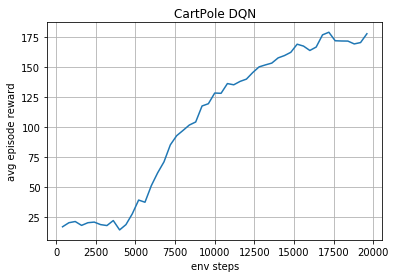

In [7]:
plot_curve('cartpole_dqn/log.txt', 'CartPole DQN')

### 1.4 Actor-Critic Algorithm

Policy gradient methods are another class of algorithms that originated from viewing the RL problem as a mathematical optimization problem. Recall that the objective of RL is to maximize the expected cumulative reward the agent gets, namely
$$
\max_{\pi} J(\pi) := \mathbb{E}_{ (s_t,a_t,r_t)\sim D^{\pi} } \left[ \sum_{t=0}^{\infty} \gamma^t r_t \right]
$$
where $D^{\pi}$ is the distribution of trajectories induced by policy $\pi$, and inside the expectation is the random variable representing the discounted cumulative reward and $J$ is the reward (or cost) functional. Essentially, we want to optimize the policy $\pi$.

The most straightforward way is to run gradient update on the parameter $\theta$ of a *parameterized* policy $\pi_{\theta}$. One such algorithm is the so-called `Advantage Actor-Critic (A2C)`. A2C is an on-policy policy optimization type algorithm. While collecting on-policy data, we iteratively run gradient ascent:
$$
\theta_{new} \leftarrow \theta_{old} + \eta { \hat \nabla_{\theta} } J(\pi_{\theta_{old}})
$$
with a Monte Carlo estimate ${ \hat \nabla_{\theta} } J$ of the true gradient $\nabla_{\theta} J$. The true gradient writes as (by Policy Gradient Theorem and some manipulations):
$$
\nabla_{\theta} J(\pi_{\theta_{old}}) = \mathbb{E}_{ (s_t,a_t,r_t)\sim D^{ \pi_{\theta_{old}} } } \sum_{t=0}^{\infty} \left( \nabla_{\theta} \log \pi_{\theta_{old}} (s_t, a_t) \left( \sum_{t'=t}^{\infty} \gamma^{t'-t} r_{t'} - V^{ \pi_{\theta_{old}} }(s_t) \right) \right)  .
$$
The quantity in the inner-most parentheses $A(s_t, a_t) = Q(s_t, a_t) - V(s_t) = (\mathbb{E} \sum_{t'=t}^{\infty} \gamma^{t'-t} r_{t'}) - V(s_t)$ is called the *Advantage* function (not very rigoriously speaking...). That's why it's called **Advantage** Actor-Critic. More on A2C: https://arxiv.org/abs/1506.02438.

And the Monte Carlo estimate of the gradient is
$$
{ \hat \nabla_{\theta} } J(\pi_{\theta_{old}}) = \frac1{NT}  \sum_{i=1}^N \sum_{t=0}^T \left( \nabla_{\theta} \log \pi_{\theta_{old}} (s_t^{i}, a_t^{i}) \left( \sum_{t'=t}^T \gamma^{t'-t} r_{t'}^{i} - V_{\phi_{old}}(s_t^{i}) \right) \right)
$$
where $V_{\phi_{old}}$ is introduced as a *parameterized* estimate for $V^{ \pi_{\theta_{old}} }$, which can also be a neural network. So $V_{\phi}$ is the **critic** and $\pi_{\theta}$ is the **actor**. We can construct a specific loss function in pytorch that gives ${ \hat \nabla_{\theta} } J$. $V_{\phi_{old}}$ is trained with SGD on a L2 loss function. It's further common practice to add an entropy bonus loss term to encourage maximum entropy solution, to facilitate exploration and avoid getting stuck in local minima. We shall clarify these loss functions in the following summarization.

#### Summarizing a variant of the A2C algorithm:
> For many iterations repeat:
1. Collect $N$ independent trajectories $\{ (s_t^{i},a_t^{i},r_t^{i})_{t=0}^T \}_{i=1}^{N}$ by running policy $\pi_{\theta}$ for maximum $T$ steps;
2. Compute the loss function for the policy parameter $\theta$:
$$
L_{policy}(\theta) = \frac1{NT} \sum_{i=1}^N \sum_{t=0}^T \left( \log \pi_{\theta} (s_t^{i}, a_t^{i}) \left( \sum_{t'=t}^T \gamma^{t'-t} r_{t'}^{i} - V_{\phi}(s_t^{i}) \right) \right)
$$
Compute the entropy term for $\theta$:
$$
L_{entropy}(\theta) = \frac1{NT} \sum_{i=1}^N \sum_{t=0}^T \left( - \sum_{a\in A} \pi_{\theta}(s_t^{i}, a) \log \pi_{\theta}(s_t^{i}, a) \right)
$$
Compute the loss for value function parameter $\phi$:
$$
L_{value}(\phi) = \frac1{NT} \sum_{i=1}^N \sum_{t=0}^T \left( \sum_{t'=t}^T \gamma^{t'-t} r_{t'}^{i} - V_{\phi}(s_t^{i}) \right)^2
$$
3. Use pytorch auto-differentiation and optimizer to do one gradient step on $(\theta, \phi)$ with the overall loss:
$$
L(\theta, \phi) = - L_{policy} - \lambda_{ent} L_{entropy} + \lambda_{val} L_{value}
$$
where $\lambda_{ent}$ and $\lambda_{val}$ are coefficients to balances the loss terms.

##### C4 (10 pts): Complete the code for computing the advantange, entropy and loss function in `A2C.train` in file `Algo.py`

##### P2 (10 pts): Run A2C on CartPole and plot the learning curve (i.e. averaged episodic reward against training iteration).
Your code should be able to achieve **>150** averaged reward in 10000 iterations (40000 simulation steps) in only a few minutes. This is a good indication that the implementation is correct.

In [1]:
%run Main.py  \
    --niter 10000   \
    --env CartPole-v1   \
    --algo a2c  \
    --nproc 4   \
    --lr 0.001  \
    --train_freq 16 \
    --train_start 0 \
    --batch_size 64     \
    --discount 0.996    \
    --value_coef 0.01    \
    --print_freq 200    \
    --checkpoint_freq 20000 \
    --save_dir cartpole_a2c \
    --log log.txt \
    --parallel_env 0

Namespace(algo='a2c', batch_size=64, checkpoint_freq=20000, discount=0.996, ent_coef=0.01, env='CartPole-v1', eps_decay=200000, frame_skip=1, frame_stack=4, load='', log='log.txt', lr=0.001, niter=10000, nproc=4, parallel_env=0, print_freq=200, replay_size=1000000, save_dir='cartpole_a2c/', target_update=2500, train_freq=16, train_start=0, value_coef=0.01)
observation space: Box(4,)
action space: Discrete(2)
running on device cpu
shared net = False, parameters to optimize: [('fc1.weight', torch.Size([128, 4]), True), ('fc1.bias', torch.Size([128]), True), ('fc2.weight', torch.Size([2, 128]), True), ('fc2.bias', torch.Size([2]), True), ('fc1.weight', torch.Size([128, 4]), True), ('fc1.bias', torch.Size([128]), True), ('fc2.weight', torch.Size([1, 128]), True), ('fc2.bias', torch.Size([1]), True)] 

obses on reset: 4 x (4,) float32
iter    200 |loss   0.84 |n_ep    26 |ep_len   26.5 |ep_rew  26.50 |raw_ep_rew  26.50 |env_step    800 |time 00:00 rem 00:06
iter    400 |loss   0.84 |n_ep   

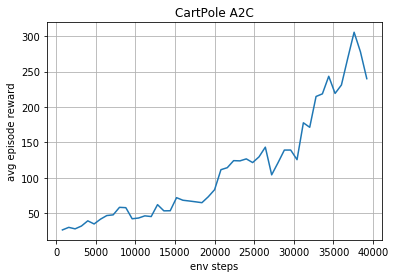

In [10]:
plot_curve('cartpole_a2c/log.txt', 'CartPole A2C')

Now let's play a little bit with the trained agent. The neural net parameters are saved to the `cartpole_dqn` and `cartpole_a2c` folders. The cell below will open a window showing one episode play.

In [3]:
import time
import gym
import Algo
env = gym.make('CartPole-v1')
agent = Algo.ActorCritic(env.observation_space, env.action_space)
agent.load('cartpole_a2c/9999.pth')
state = env.reset()
for _ in range(120):
    env.render()
    state, reward, done, _ = env.step(agent.act([state])[0])
    if done: break
    time.sleep(0.1)
env.close()

shared net = False, parameters to optimize: [('fc1.weight', torch.Size([128, 4]), True), ('fc1.bias', torch.Size([128]), True), ('fc2.weight', torch.Size([2, 128]), True), ('fc2.bias', torch.Size([2]), True), ('fc1.weight', torch.Size([128, 4]), True), ('fc1.bias', torch.Size([128]), True), ('fc2.weight', torch.Size([1, 128]), True), ('fc2.bias', torch.Size([1]), True)] 



## Part II: Solve the Atari Breakout game
***
In this part, you'll train your agent to play Breakout with the BlueWaters cluster. I have provided the job scripts for you. Please upload your `Algo.py` and `Model.py` completed in **Part I** to your BlueWaters folder. And submit the following two jobs respectively:
```
qsub run_dqn.pbs
qsub run_a2c.pbs
```

The jobs are set to run for at most **14 hours**. **<font color=red>Please start early!!</font>** You might be able to reach the desired score (>= 200 reward) before 14 hours - You can stop the training early if you wish. Then please collect the resulting `breakout_dqn/log.txt` and `breakout_a2c/log.txt` files into the same folder as this Jupyter notebook's. Rename them as `log_breakout_dqn.txt` and `log_breakout_a2c.txt`.

BTW, there's an Atari PC simulator: https://stella-emu.github.io/ I spent a lot of time playing them...

##### C5 (10 pts): Complete the code for the CNN with 3 conv layers and 3 fc layers in class `SimpleCNN` in file `Model.py`
And verify the output shape with the cell below.

In [1]:
## Test code
from Model import SimpleCNN
import torch
net = SimpleCNN()
x = torch.randn(2, 4, 84, 84)
y = net(x)
assert y.shape == (2, 4), "ERROR: network output has the wrong shape!"
print ("CNN output shape test passed!")

CNN output shape test passed!


##### P3 (10 pts): Run the following cell to generate a DQN learning curve.
The *maximum* average episodic reward on this curve should be larger than $200$ for full credit. (It's ok if the final reward is not as high.) The typical value is around $300$. You get 70% credit if $100 \le$ average episodic reward $< 200$, 50% credit if $50 \le$ average episodic reward $< 100$.

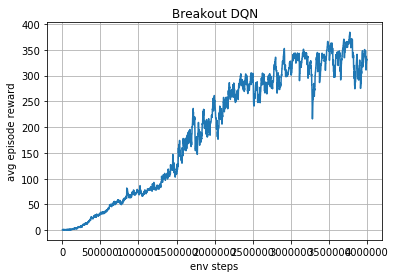

In [4]:
plot_curve('log_breakout_dqn.txt', 'Breakout DQN')

##### P4 (10 pts): Run the following cell to generate an A2C learning curve.
The *maximum* average episodic reward on this curve should be larger than $150$ for full credit. (It's ok if the final reward is not as high.) The typical value is around $250$. You get 70% credit if $50 \le$ average episodic reward $< 150$, and 50% credit if $20 \le$ average episodic reward $< 50$.

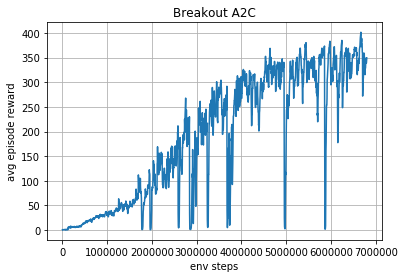

In [4]:
plot_curve('log_breakout_a2c.txt', 'Breakout A2C')

##### P5 (10 pts): Collect and visualize some game frames by running the script `Draw.py` on BlueWaters.
(1) `module load python/2.0.0` and run `Draw.py` on BlueWaters (it's ok to run this locally, no need to start a job).

(2) Download the result `breakout_imgs` folder from BlueWaters to the folder containing this Jupyter notebook, and run the following cell. You should see some animation of the game.

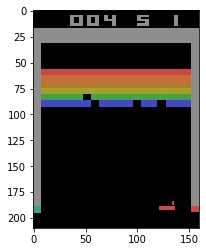

In [3]:
import os
imgs = sorted(os.listdir('breakout_imgs'))
#imgs = [plt.imread('breakout_imgs/' + img) for img in imgs]

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
pimg = None
for img in imgs:
    img = plt.imread('breakout_imgs/' + img)
    if pimg:
        pimg.set_data(img)
    else:
        pimg = plt.imshow(img)
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Part III: Questions (10 pts)
***

These are open-ended questions. The purpose is to encourage you to think (a bit) more deeply about these algorithms. You get full points as long as you write a few sentences that make sense and show some thinking.

##### Q1 (2 pts): Why would people want to do function approximation rather than using tabular algorithm (on discretized S,A spaces if necessary)? Bringing function approximation has caused numerous problems theoretically (e.g. not guaranteed to converge), so it seems not worth it...

##### Q2 (2 pts): Q-Learning seems good... it's theoretically sound (at least seems to be), the performance is also good. Why would many people actually prefer policy gradient type algorithms in some practical problems?

##### Q3 (2 pts): Does the policy gradient algorithm (A2C) we implemented here extend to continuous action space? How would you do that? Hint: What is a reasonable distribution assumption for policy $\pi_{\theta}(a|s)$ if $a$ lives in continuous space?

##### Q4 (2 pts): The policy gradient algorithm (A2C) we implemented uses on-policy data. Can you think of a way to extend it to utilize off-policy data? Hint: Importance sampling, needs some approximation though

##### Q5 (2 pts): How to compare different RL algorithms? When can I say one algorithm is better than the other? Hint: This question is quite open. Think about speed, complexity, tasks, etc.